In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qml.kernels import gaussian_kernel
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import math
import random

In [2]:
def check_duplicate(array):
    """
    Check if any two elements in an array are equal.
    Used in the check_shuffles() function to make sure all the shuffles are distinct.

    Parameters:
        array: A list or array of numpy ndarrays.

    Returns:
        True if any two elements in the array are equal, False otherwise.
    """
    seen = set()
    for element in array:
        temp_element = tuple(element.flatten())
        if temp_element in seen:
            return True
        seen.add(temp_element)
    return False
def check_shuffles():
    """
    Check the shuffles used for a given dataset to ensure they are distinct.
    Returns:
        True if no duplicate shuffles are found, False otherwise.
    """
    for i in range(3):
        if check_duplicate(shuffles_output_dummy[i])== True:
            return False
    if check_duplicate(shuffles_x_dummy)==True:
        return False
    return True

In [3]:
np.random.seed(27)
def f1(x):
    return np.sin(x[:, 0]) + np.cos(x[:, 1]) + np.exp(x[:, 2]) + np.sin(x[:, 3]) + np.cos(x[:, 4])
def f2(x):
    return np.cos(x[:, 0]) + np.exp(x[:, 1]) + np.sin(x[:, 2]) + np.cos(x[:, 3]) + np.exp(x[:, 4])
def f3(x):
    return np.sin(x[:, 0]) + np.exp(x[:, 1]) + np.cos(x[:, 2]) + np.sin(x[:, 3]) + np.exp(x[:, 4])
# Generate 3000 samples of 5 dimensional input X with random numbers between 0 and 1
X = np.random.rand(3000, 5)

# Generate 3 dimensional output Y using output functions
Y = np.zeros((3000, 3))
Y[:, 0] = f1(X)
Y[:, 1] = f2(X)
Y[:, 2] = f3(X)

In [4]:

def rotation_matrix(axis, theta):
    """
    Creates a rotation matrix given the axes about 
    which to rotate and the angle
    using Euler-Rodrigues formula
    
    Parameters:
        axis(numpy array): array indicated about which axes to rotate
        theta(int): rotation angle, in radians
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

rotated_Y = np.zeros((3000, 3))

#45 degree rotation about the all axes
for i in range(len(Y)):
    rotated_Y[i] = np.dot(rotation_matrix([1, 1, 1], np.deg2rad(45)), Y[i])


In [5]:
def create_shuffles(X, Y):
    """
    Create 10 shuffled versions of input and output data for a given dataset.
    
    Parameters:
        X(numpy ndarray): input data
        Y(numpy ndarray): output data   
    """
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)

    
    indices=list(range(Y_train.shape[0]))

    shuffles_x=[]
    shuffles_y1=[]
    shuffles_y2=[]
    shuffles_y3=[]

    for i in range(10):
        random.shuffle(indices)
        x_shuffled=X_train[indices]
        y_shuffled=Y_train[indices]
        
        y1=y_shuffled[:,0]
        y2=y_shuffled[:,1]
        y3=y_shuffled[:,2]
        shuffles_x.append(x_shuffled)
        shuffles_y1.append(y1)
        shuffles_y2.append(y2)
        shuffles_y3.append(y3)


    np.save('../Dummy Data/Dummy Shuffles/shuffles_x_rotated_dummy', shuffles_x)
    np.save('../Dummy Data/Dummy Shuffles/shuffles_y1_rotated_dummy', shuffles_y1)
    np.save('../Dummy Data/Dummy Shuffles/shuffles_y2_rotated_dummy', shuffles_y2)
    np.save('../Dummy Data/Dummy Shuffles/shuffles_y3_rotated_dummy', shuffles_y3)


In [6]:
#Commented out to not create new shuffles at every code run. Guarantees consistency across multiple calls.
#create_shuffles(X,rotated_Y)
shuffles_x_dummy = np.load('../Dummy Data/Dummy Shuffles/shuffles_x_rotated_dummy.npy')
shuffles_output_dummy=[np.load('../Dummy Data/Dummy Shuffles/shuffles_y1_rotated_dummy.npy'),np.load('../Dummy Data/Dummy Shuffles/shuffles_y2_rotated_dummy.npy'),np.load('../Dummy Data/Dummy Shuffles/shuffles_y3_rotated_dummy.npy')]
if check_shuffles()==False:
    print("Two or more shuffles are identical. Please run setup again to reshuffle")

In [7]:
from qml.math import cho_solve
def krr_qml(x_train,x_test,y_train,y_test,sigma):
    """
    Kernel Ridge Regression using QML package.

    Parameters:
        x_train (numpy array): Input data for training, corresponding to an array of Coulomb Matrices.
        x_test (numpy array): Input data for testing, corresponding to an array of Coulomb Matrices.
        y_train (numpy array): Output data for training, corresponding to an array of scalar values.
        y_test (numpy array): Output data for testing, corresponding to an array of scalar values.
        sigma (float): Kernel width.
        
    Returns:
                MAE(float): Mean absolute error over the test samples of the model.
    """
    K=gaussian_kernel(x_train,x_train,sigma=sigma)
    K[np.diag_indices_from(K)] += 1e-9
    alpha = cho_solve(K, y_train)
    Ks=gaussian_kernel(x_train,x_test,sigma)
    y_predict=np.dot(alpha,Ks) 
    return np.mean(np.abs(y_predict - y_test))


In [8]:
def largest_power_of_two(N):
    """
    Find the largest power of two less than or equal to a given integer.
    
    This function takes the training set size N as input and returns the largest power of two less than or equal to N.
    It also returns a list of all powers of two less than or equal to N.
    
    Parameters:
        N (int): A positive integer.
        
    Returns:
        A tuple containing:
            - An integer representing the largest power of two less than or equal to N.
            - A list of all powers of two less than or equal to N.
    """
    n = 0
    while 2**n < N:
        n += 1
    
    powers = []
    for i in range(1,n):
        if 2**i <= N:
            powers.append(2**i)
        else:
            break
    return n - 1,powers

largest_two,train_sizes=largest_power_of_two(len(X))

In [9]:
def learning_curve(x_train,x_test,y_train,y_test,krr_function,sigma,shuffles_component):
    """
    Calculates the mean absolute errors of different training sizes for a given dataset and kernel ridge regression function.

    Parameters:
        x_test (numpy array): Input data for testing.
        y_test (numpy array): Output data for testing.
        krr_function (function): The KRR function to be used (QML or Sklearn).
        sigma (float): Kernel width.
        shuffles_component (list of numpy arrays): A list of shuffled output data arrays for the training set.

    Returns:
        mae_list (numpy array): An array of mean absolute errors for each training size in the learning curve.
    """
    mae_list=np.zeros(largest_two,dtype=float)
    for j in range(10):
        X_train1,y_train1=shuffles_x_dummy[j],shuffles_component[j]
        maes=[]

        for i in (2**p for p in range(1,largest_two+1)):
                temp_mae=krr_function(X_train1[0:i],x_test,y_train1[0:i],y_test,sigma)

                maes.append(temp_mae)
        mae_list[:]=np.copy(maes)
    mae_list=mae_list/10
    return mae_list

In [10]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, rotated_Y, shuffle=False, train_size=0.8)

def lc_plots(krrfunction):
    '''
    Plots the learning curves for the transition dipole moment components of a given dataset using a given kernel ridge regression function.

    Parameters:
        krrfunction (function): The KRR function to be used (QML or Sklearn).
     '''
    lc_results=[]
    sigma=100
    for i in range (3):
        shuffles_component=shuffles_output_dummy[i]
        y_train1_temp=y_train1[:,i]
        y_test1_temp=y_test1[:,i]
        temp_result=learning_curve(X_train1,X_test1,y_train1_temp,y_test1_temp,krrfunction,sigma,shuffles_component)    
        lc_results.append(temp_result)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Learning Curves for the output components', fontsize=16)
    for i, ax in enumerate(axs):
        ax.loglog(train_sizes, lc_results[i], marker='.', markersize=10, linewidth=2, color='tab:cyan')
        ax.set_xlabel('Number of Training Samples', fontsize=14)
        ax.set_ylabel('Mean Absolute Error', fontsize=14)
        ax.set_title(f'Component {chr(88+i)}', fontsize=16)

    plt.show()

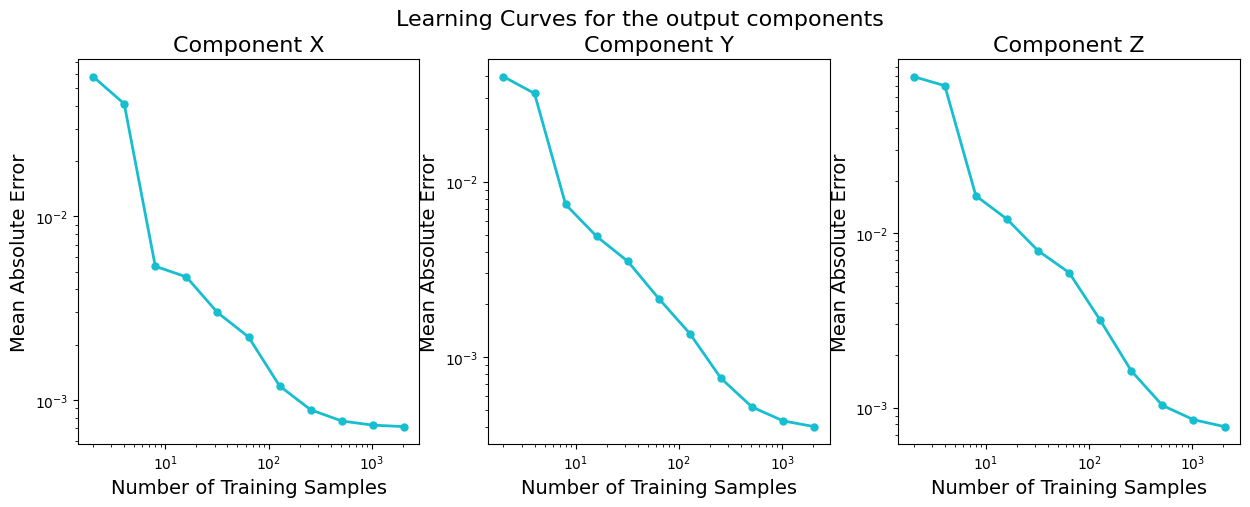

In [11]:
lc_plots(krr_qml)

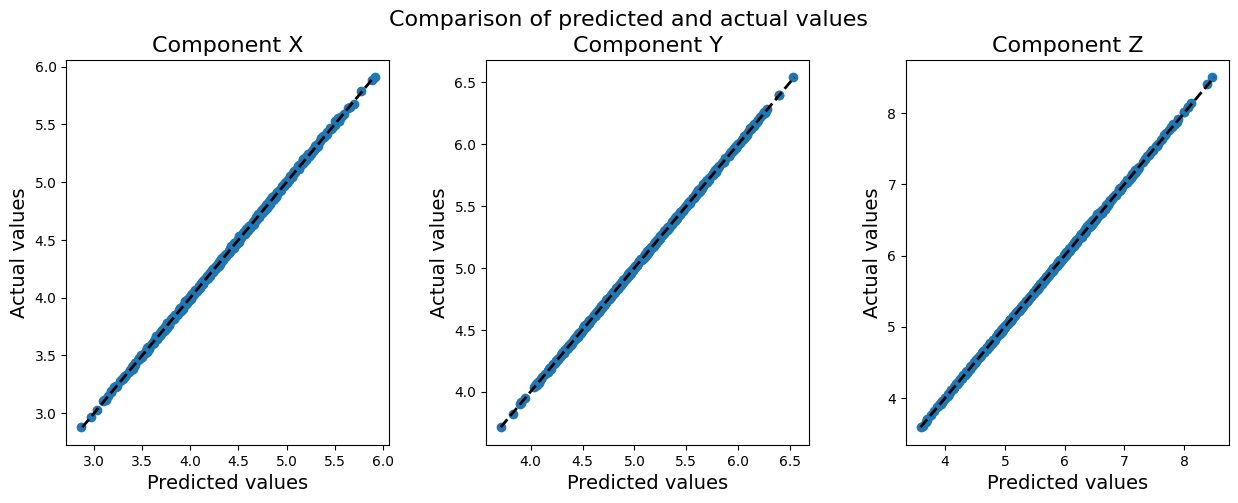

In [12]:
def krr_qml_predicted(x_train,x_test,y_train,y_test,sigma):
    """
    Kernel Ridge Regression using QML package.

    Parameters:
        x_train (numpy array): Input data for training, 
        x_test (numpy array): Input data for testing
        y_train (numpy array): Output data for training, corresponding to an array of scalar values.
        y_test (numpy array): Output data for testing, corresponding to an array of scalar values.
        sigma (float): Kernel width.
        
    Returns:
        y_predict(numpy array): The values predicted for the given testing data.
    """
    from qml.math import cho_solve
    
    K=gaussian_kernel(x_train,x_train,sigma=sigma)
    K[np.diag_indices_from(K)] += 1e-9
    alpha = cho_solve(K, y_train)
    Ks=gaussian_kernel(x_train,x_test,sigma)
    y_predict=np.dot(alpha,Ks) 
    
    return y_predict

predicted_values_results=[]
for i in range (3):
    sigma=100
    y_train1_temp=y_train1[:,i]
    y_test1_temp=y_test1[:,i]
    y_predicted_values=krr_qml_predicted(X_train1,X_test1,y_train1_temp,y_test1_temp,sigma)
    predicted_values_results.append(y_predicted_values)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Comparison of predicted and actual values', fontsize=16)
for i, ax in enumerate(axs):
    ax.plot([y_test1[:,i].min(), y_test1[:,i].max()], [y_test1[:,i].min(), y_test1[:,i].max()], 'k--', lw=2)
    ax.scatter(predicted_values_results[i],y_test1[:,i])
    ax.set_xlabel('Predicted values', fontsize=14)
    ax.set_ylabel('Actual values', fontsize=14)
    ax.set_title(f'Component {chr(88+i)}', fontsize=16)
plt.subplots_adjust(wspace=0.3)
plt.show()
